In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train=pd.read_csv('train.csv')
df_train.head()

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,29.0,4,135.0,84.00,2525.0,16.0,82,1,dodge aries se
1,3,31.9,4,89.0,71.00,1925.0,14.0,79,2,vw rabbit custom
2,9,19.0,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii
3,11,28.0,4,90.0,75.00,2125.0,14.5,74,1,dodge colt
4,13,37.7,4,89.0,62.00,2050.0,17.3,81,3,toyota tercel


In [3]:
#前処理をする関数
def preprocessing(df):
    
    #'欠損値：?'を文字列の0に一次補完
    df['horsepower']=df['horsepower'].replace('?','0.00')
    
    #文字列型から浮動小数点数型に変換
    df['horsepower']=df['horsepower'].astype('float')
    
    #馬力の欠損値補完
    df.horsepower[df['horsepower'] <= 0] = df[df['horsepower'] <= 0].apply(lambda x:df.query('horsepower > 0').groupby(['cylinders','origin']).horsepower.mean()[x.cylinders][x.origin],axis=1)   
    
    #カテゴリカル変数に変換
    df['car name']=df['car name'].astype('category')
    
    #id は削除
    df=df.drop('id', axis=1)
    return df 

### 学習用

In [4]:
df_train=preprocessing(df_train)

#説明変数
X=df_train.drop(['mpg'], axis=1)
#目的変数
y=df_train['mpg']


/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_2711/3089231402.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.horsepower[df['horsepower'] <= 0] = df[df['horsepower'] <= 0].apply(lambda x:df.query('horsepower > 0').groupby(['cylinders','origin']).horsepower.mean()[x.cylinders][x.origin],axis=1)


### テスト用

In [5]:
df_test=pd.read_csv('test.csv')
df_test.head()

,id,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,1,6,145.0,76.00,3160.0,19.6,81,2,volvo diesel
1,2,6,250.0,98.00,3525.0,19.0,77,1,ford granada
2,4,4,119.0,92.00,2434.0,15.0,80,3,datsun 510 hatchback
3,5,6,258.0,110.0,2962.0,13.5,71,1,amc hornet sportabout (sw)
4,6,4,97.0,88.00,2100.0,16.5,72,3,toyota corolla 1600 (sw)


In [6]:
df_test=preprocessing(df_test)

/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_2711/3089231402.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.horsepower[df['horsepower'] <= 0] = df[df['horsepower'] <= 0].apply(lambda x:df.query('horsepower > 0').groupby(['cylinders','origin']).horsepower.mean()[x.cylinders][x.origin],axis=1)


In [7]:
from sklearn.model_selection import train_test_split

#訓練データを学習用と検証用に分割
train_X, val_X, train_y, val_y=train_test_split(X, y, test_size=0.15, random_state=0)


### GridSearch

In [9]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

lgb_reg2=lgb.LGBMRegressor(n_estimators=5000)

params={
    'max_depth':[i for i in range(1,6)],
    'num_leaves': [2**i for i in range(1,6)],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid=GridSearchCV(
    estimator=lgb_reg2,
    param_grid=params,
    cv=5,
    scoring='neg_mean_squared_error',
#     verbose=10
)

grid.fit(train_X, train_y)

print('ベストスコア ', grid.best_score_)
print('最適なハイパーパラメータ　', grid.best_params_)


KeyboardInterrupt: 

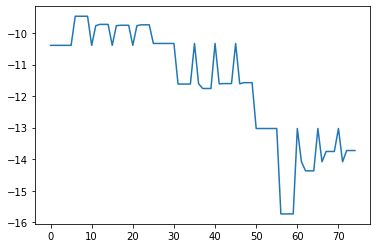

In [13]:
#テストスコアの折れ線グラフ
r=grid.cv_results_['mean_test_score'].tolist()
x=np.arange(len(r))

plt.plot(x,r)
plt.show()

In [49]:
lgb_reg2=lgb.LGBMRegressor(
    max_depth=1,
    num_leaves=2,
    learning_rate=0.01
)

lgb_reg2.fit(train_X, train_y)

pred_train=lgb_reg2.predict(train_X)
pred_val=lgb_reg2.predict(val_X)

In [50]:
from sklearn.metrics import mean_squared_error

print('学習用：　', np.sqrt(mean_squared_error(y_true=train_y, y_pred=pred_train)))
print('テスト用：　', np.sqrt(mean_squared_error(y_true=val_y, y_pred=pred_val)))

学習用：　 5.17502597444488
テスト用：　 4.672118951818142


In [10]:
params={
     'objective': 'regression_l2',
     'metric': 'mean_squared_error',
     'verbosity': -1,
     'n_jobs': -1,
     'feature_pre_filter': False,
     'lambda_l1': 0.020598502667132295,
     'lambda_l2': 0.9430074594421136,
     'num_leaves': 3,
     'feature_fraction': 0.6799999999999999,
     'bagging_fraction': 0.7239855675688142,
     'bagging_freq': 1,
     'min_child_samples': 10,
     'num_iterations': 100000,
     'early_stopping_round': 100,
     'categorical_column': [7]
}

trains=lgb.Dataset(train_X, train_y)
vals=lgb.Dataset(val_X, val_y)

lgb_reg1=lgb.train(params, trains, valid_sets=vals, num_boost_round=10000, early_stopping_rounds=100)

/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias

[1]	valid_0's l2: 45.007
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 39.3209
[3]	valid_0's l2: 34.4233
[4]	valid_0's l2: 30.4243
[5]	valid_0's l2: 27.4413
[6]	valid_0's l2: 24.3809
[7]	valid_0's l2: 21.9709
[8]	valid_0's l2: 19.6843
[9]	valid_0's l2: 17.7696
[10]	valid_0's l2: 16.5843
[11]	valid_0's l2: 15.5835
[12]	valid_0's l2: 14.5125
[13]	valid_0's l2: 13.7443
[14]	valid_0's l2: 13.1341
[15]	valid_0's l2: 12.1033
[16]	valid_0's l2: 11.182
[17]	valid_0's l2: 10.4479
[18]	valid_0's l2: 10.0404
[19]	valid_0's l2: 9.37798
[20]	valid_0's l2: 8.77847
[21]	valid_0's l2: 8.4149
[22]	valid_0's l2: 8.3517
[23]	valid_0's l2: 8.32015
[24]	valid_0's l2: 8.34135
[25]	valid_0's l2: 8.11959
[26]	valid_0's l2: 7.79726
[27]	valid_0's l2: 7.47994
[28]	valid_0's l2: 7.33013
[29]	valid_0's l2: 7.34757
[30]	valid_0's l2: 6.9974
[31]	valid_0's l2: 6.89116
[32]	valid_0's l2: 6.80613
[33]	valid_0's l2: 6.94286
[34]	valid_0's l2: 6.81667
[35]	valid_0's l2: 6.7781
[36]	val

In [14]:
from sklearn.metrics import mean_squared_error

pred_train1=lgb_reg1.predict(train_X)
pred_val1=lgb_reg1.predict(val_X)
pred_X=lgb_reg1.predict(X)


print('学習用：', np.sqrt(mean_squared_error(y_true=train_y, y_pred=pred_train1)))
print('検証用：', np.sqrt(mean_squared_error(y_true=val_y, y_pred=pred_val1)))
print('訓練用：', np.sqrt(mean_squared_error(y_true=y, y_pred=pred_X)))



学習用： 2.3831164935074582
検証用： 2.4986429949040363
訓練用： 2.400888422178603


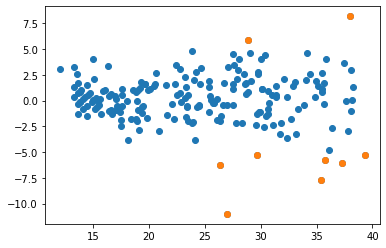

In [43]:
# plt.scatter(pred_train1, pred_train1-train_y)
# plt.scatter(pred_val1, pred_val1-val_y)
plt.scatter(pred_X, pred_X-y)
plt.scatter(pred_X[diff[np.abs(diff)>5.0].index], diff[np.abs(diff)>5.0])

plt.show()

In [57]:
diff=pred_X-y
diff[np.abs(diff)>5.0].index

Int64Index([19, 29, 40, 49, 101, 123, 124, 180, 197], dtype='int64')

In [58]:
diff[np.abs(diff)>5.0]

19     -6.286923
29    -11.010750
40     -7.674288
49     -5.308926
101     8.187045
123    -5.748657
124     5.870914
180    -5.327233
197    -6.104169
Name: mpg, dtype: float64

In [41]:
train_X[np.abs(diff)>5.0]

/var/folders/ks/17djw9_d5r3300_0z8cc33sh0000gn/T/ipykernel_2711/1083973959.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_X[np.abs(diff)>5.0]


,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
40,4,90.0,48.0,1985.0,21.5,78,2,volkswagen rabbit custom diesel
180,4,72.0,69.0,1613.0,18.0,71,3,datsun 1200
19,6,168.0,132.0,2910.0,11.4,80,3,datsun 280-zx
123,4,98.0,76.0,2144.0,14.7,80,2,vw rabbit
101,4,89.0,62.0,1845.0,15.3,80,2,vokswagen rabbit
49,4,91.0,67.0,1850.0,13.8,80,3,honda civic 1500 gl
197,4,90.0,48.0,2335.0,23.7,80,2,vw dasher (diesel)
29,6,262.0,85.0,3015.0,17.0,82,1,oldsmobile cutlass ciera (diesel)


In [54]:
X[np.abs(diff)>5.0].drop('car name', axis=1)

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
19,6,168.0,132.0,2910.0,11.4,80,3
29,6,262.0,85.0,3015.0,17.0,82,1
40,4,90.0,48.0,1985.0,21.5,78,2
49,4,91.0,67.0,1850.0,13.8,80,3
101,4,89.0,62.0,1845.0,15.3,80,2
123,4,98.0,76.0,2144.0,14.7,80,2
124,4,97.0,54.0,2254.0,23.5,72,2
180,4,72.0,69.0,1613.0,18.0,71,3
197,4,90.0,48.0,2335.0,23.7,80,2


In [45]:
!pip install umap-learn

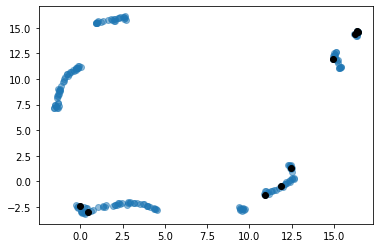

In [64]:
import umap

umap=umap.UMAP(n_components=2, random_state=0)
X_umap2D=umap.fit_transform(X.drop('car name', axis=1))
# out_X_umap=umap.fit_transform(X[np.abs(diff)>5.0].drop('car name', axis=1))

plt.scatter(X_umap2D[:,0], X_umap2D[:,1], cmap='jet', c=X['cylinders'], alpha=0.5)
# plt.scatter(out_X_umap[np.abs(diff)>5.0,0], out_X_umap[np.abs(diff)>5.0,1], c='b', cmap='jet', alpha=0.5)
plt.scatter(X_umap2D[np.abs(diff)>5.0,0], X_umap2D[np.abs(diff)>5.0,1], c='k', cmap='jet')


plt.show()

In [68]:
_X=X.drop('car name', axis=1)
_X.columns

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin'],
      dtype='object')

In [79]:
_out_X=X[np.abs(diff)>5.0]
_out_X

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
19,6,168.0,132.0,2910.0,11.4,80,3,datsun 280-zx
29,6,262.0,85.0,3015.0,17.0,82,1,oldsmobile cutlass ciera (diesel)
40,4,90.0,48.0,1985.0,21.5,78,2,volkswagen rabbit custom diesel
49,4,91.0,67.0,1850.0,13.8,80,3,honda civic 1500 gl
101,4,89.0,62.0,1845.0,15.3,80,2,vokswagen rabbit
123,4,98.0,76.0,2144.0,14.7,80,2,vw rabbit
124,4,97.0,54.0,2254.0,23.5,72,2,volkswagen type 3
180,4,72.0,69.0,1613.0,18.0,71,3,datsun 1200
197,4,90.0,48.0,2335.0,23.7,80,2,vw dasher (diesel)


In [73]:
_X.columns[0]

'cylinders'

In [80]:
out_index=diff[np.abs(diff)>5.0].index
y[out_index]

19     32.7
29     38.0
40     43.1
49     44.6
101    29.8
123    41.5
124    23.0
180    35.0
197    43.4
Name: mpg, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


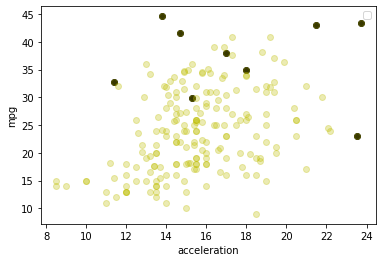

In [99]:
i=4
plt.scatter(_out_X[_X.columns[i]], y[out_index], c='k')
plt.scatter(X[_X.columns[i]], y, c='y', alpha=0.3)
plt.xlabel(_X.columns[i])
plt.ylabel('mpg')
plt.legend()
plt.show()

### optuna

In [36]:
import optuna.integration.lightgbm as lgb_tune
import time

dtrain=lgb.Dataset(train_X, label=train_y)
dval=lgb.Dataset(val_X, label=val_y)

params = {
    "objective": "regression_l2",
    "metric": "mean_squared_error",
    'n_estimators': 500000, 
    'verbosity':-1,
    'n_jobs':-1
}

s=time.time()
lgb_tuned1 = lgb_tune.train(params, dtrain, 
                    valid_sets=[dtrain, dval],
                    verbose_eval=False,
                    early_stopping_rounds=100,
                    )
e=time.time()
print(e-s)

[I 2022-09-14 17:17:26,280] A new study created in memory with name: no-name-5f6e01f1-f545-421b-971d-ab7906480e60
feature_fraction, val_score: inf:   0%|                   | 0/7 [00:00<?, ?it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGB

/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
feature_fraction, val_score: 6.133417:  57%|###4  | 4/7 [00:00<00:00,  5.13it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarnin

num_leaves, val_score: 6.133417:   5%|5          | 1/20 [00:00<00:03,  5.54it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is d

/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
num_leaves, val_score: 6.133417:  25%|##7        | 5/20 [00:00<00:02,  5.65it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instea

num_leaves, val_score: 6.133417:  45%|####9      | 9/20 [00:01<00:02,  5.12it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is d

num_leaves, val_score: 6.133417:  65%|######5   | 13/20 [00:02<00:01,  6.75it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is d

num_leaves, val_score: 6.133417:  85%|########5 | 17/20 [00:02<00:00,  7.49it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is d

bagging, val_score: 6.133417:  10%|#4            | 1/10 [00:00<00:01,  6.20it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is d

bagging, val_score: 6.133417:  50%|#######       | 5/10 [00:00<00:00,  8.20it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is d

bagging, val_score: 5.965116:  90%|############6 | 9/10 [00:01<00:00,  7.92it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is d

feature_fraction_stage2, val_score: 5.965116:  50%|5| 3/6 [00:00<00:00,  5.95it/[I 2022-09-14 17:17:32,683] Trial 39 finished with value: 5.965116325598841 and parameters: {'feature_fraction': 0.616}. Best is trial 38 with value: 5.965116325598841.
feature_fraction_stage2, val_score: 5.965116:  50%|5| 3/6 [00:00<00:00,  5.95it//Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site

/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
regularization_factors, val_score: 5.951909:   5%| | 1/20 [00:00<00:02,  7.23it/[I 2022-09-14 17:17:33,273] Trial 43 finished with value: 5.9519089548095305 and parameters: {'lambda_l1': 1.2838443076086867, 'lambda_l2': 1.7791158813687422e-07}. Best is trial 43 with value: 5.9519089548095305.
regularization_factors, val_score: 5.951909:   5%| | 1/20 [00:00<00:02,  7.23it//Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. W

regularization_factors, val_score: 5.951909:  25%|2| 5/20 [00:00<00:02,  7.31it/[I 2022-09-14 17:17:33,831] Trial 47 finished with value: 6.084510405770517 and parameters: {'lambda_l1': 0.08418168870800177, 'lambda_l2': 0.057036217115818556}. Best is trial 43 with value: 5.9519089548095305.
regularization_factors, val_score: 5.951909:  25%|2| 5/20 [00:00<00:02,  7.31it//Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/

regularization_factors, val_score: 5.951909:  45%|4| 9/20 [00:01<00:01,  6.83it/[I 2022-09-14 17:17:34,417] Trial 51 finished with value: 5.965132180745195 and parameters: {'lambda_l1': 0.0013056437086376653, 'lambda_l2': 1.3366079212513158e-07}. Best is trial 43 with value: 5.9519089548095305.
regularization_factors, val_score: 5.951909:  45%|4| 9/20 [00:01<00:01,  6.83it//Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Us

regularization_factors, val_score: 5.951909:  65%|6| 13/20 [00:01<00:01,  6.01it[I 2022-09-14 17:17:35,084] Trial 55 finished with value: 5.965025462552235 and parameters: {'lambda_l1': 2.9308216114929004e-06, 'lambda_l2': 0.007493922932743347}. Best is trial 43 with value: 5.9519089548095305.
regularization_factors, val_score: 5.951909:  65%|6| 13/20 [00:01<00:01,  6.01it/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Use

regularization_factors, val_score: 5.951909:  85%|8| 17/20 [00:02<00:00,  5.26it[I 2022-09-14 17:17:35,882] Trial 59 finished with value: 6.211213914195276 and parameters: {'lambda_l1': 7.259620017209136, 'lambda_l2': 4.298041998021448e-06}. Best is trial 43 with value: 5.9519089548095305.
regularization_factors, val_score: 5.951909:  85%|8| 17/20 [00:02<00:00,  5.26it/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/S

/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
min_data_in_leaf, val_score: 5.951909:  20%|#2    | 1/5 [00:00<00:00,  8.89it/s]/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instea

/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/Shota-0128/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
min_data_in_leaf, val_score: 5.951909: 100%|######| 5/5 [00:00<00:00,  5.21it/s]

11.157331943511963


In [37]:
lgb_tuned1.params

{'objective': 'regression_l2',
 'metric': 'l2',
 'verbosity': -1,
 'n_jobs': -1,
 'feature_pre_filter': False,
 'lambda_l1': 1.2838443076086867,
 'lambda_l2': 1.7791158813687422e-07,
 'num_leaves': 63,
 'feature_fraction': 0.6,
 'bagging_fraction': 0.5645668636489155,
 'bagging_freq': 1,
 'min_child_samples': 20,
 'num_iterations': 500000,
 'early_stopping_round': 100,
 'categorical_column': [7]}

In [40]:
lgb_tuned1.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('l2', 5.44741160011532)]),
             'valid_1': OrderedDict([('l2', 5.9519089548095305)])})

In [43]:
pred_train1=lgb_reg1.predict(train_X)
pred_val1=lgb_reg1.predict(val_X)
pred_X=lgb_reg1.predict(X)


print('学習用：', np.sqrt(mean_squared_error(y_true=train_y, y_pred=pred_train1)))
print('検証用：', np.sqrt(mean_squared_error(y_true=val_y, y_pred=pred_val1)))
print('全体：', np.sqrt(mean_squared_error(y_true=y, y_pred=pred_X)))

学習用： 2.5172916376449117
検証用： 2.4356624528473443
全体： 2.505156002183617


In [45]:
#残差を変数に加える
diff=np.abs(y-pred_X)
X['diff']=diff

In [46]:
X

,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name,diff
0,4,135.0,84.0,2525.0,16.0,82,1,dodge aries se,-1.422273
1,4,89.0,71.0,1925.0,14.0,79,2,vw rabbit custom,-2.011230
2,6,156.0,108.0,2930.0,15.5,76,3,toyota mark ii,-1.124144
3,4,90.0,75.0,2125.0,14.5,74,1,dodge colt,0.155619
4,4,89.0,62.0,2050.0,17.3,81,3,toyota tercel,0.075339
...,...,...,...,...,...,...,...,...,...
194,4,85.0,65.0,2110.0,19.2,80,3,datsun 210,3.662800
195,8,302.0,139.0,3570.0,12.8,78,1,mercury monarch ghia,1.982389
196,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst,0.014614
197,4,90.0,48.0,2335.0,23.7,80,2,vw dasher (diesel),6.910484
